## Gradient Boosting Classifier
This notebook defines the python script corresponding to the non-DL scenario. The multinomial classifier I used is the **XGB** implementation which supports the GPU acceleration

In [3]:
# load training set
import pandas as pd
import numpy as np

XTrain = pd.read_csv('../../data/staging_data/mispelling_fixed_clean_input_train.csv', sep=',')
YTrain = pd.read_csv('c:/Users/I051796/Projects/CES/data/label.csv', sep=';')

##  Data Preparation

In [4]:
# vectorize the text with TF-IDF transform
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

vectorizer = TfidfVectorizer(strip_accents='ascii')
XTFIDFVectorizedTrain = vectorizer.fit_transform(XTrain['question'])
XTFIDFVectorizedTrain = pd.DataFrame(XTFIDFVectorizedTrain.toarray())
XTFIDFVectorizedTrain.head(2)

,0,1,2,3,4,5,6,7,8,9,...,8060,8061,8062,8063,8064,8065,8066,8067,8068,8069
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# perform a dimensional reduction into 600 dimensional space
# use the same dimensionality than the one provided by fasttext embedding model in the DL context
from sklearn.decomposition import PCA

PCATransform = PCA(n_components=600)
PCAXTrain = pd.DataFrame(PCATransform.fit_transform(XTFIDFVectorizedTrain))

In [6]:
from sklearn.model_selection import train_test_split
# combine input features from above text vectorization with text characteristics features (../../data/staging_data/text_extracted_features.csv)
extractedFeatures = pd.read_csv('../../data/staging_data/text_extracted_features.csv', sep=',')
mergedXTrain = PCAXTrain.join(extractedFeatures, lsuffix='', rsuffix='')

# split into train and test
mergedXTrain, mergedXTest, YTrain, YTest = train_test_split(mergedXTrain, YTrain, test_size=0.15, random_state=42)

mergedXTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,likelihood_topic_41,likelihood_topic_42,likelihood_topic_43,likelihood_topic_44,likelihood_topic_45,likelihood_topic_46,likelihood_topic_47,likelihood_topic_48,likelihood_topic_49,likelihood_topic_50
1188,0.143385,-0.123189,-0.046976,-0.025050,-0.036219,-0.031148,0.030762,-0.049410,0.067782,0.058946,...,0.0,0.0,0.02,0.0,0.04,0.0,0.0,0.0,0.04,0.0
4252,-0.105876,0.036921,-0.089553,-0.021620,0.211266,0.115868,0.115149,-0.028494,-0.000708,-0.025395,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
447,-0.080307,-0.038724,-0.039224,-0.152588,0.059370,-0.133382,0.115162,-0.044077,0.044808,0.083296,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.02,0.0
2926,0.065817,0.111077,0.150822,-0.027654,0.049189,-0.028348,-0.076515,0.058111,0.104990,0.103282,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0
3733,-0.074552,0.025587,0.039834,0.003135,0.030514,-0.033057,-0.081776,0.068321,-0.017575,0.020644,...,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.0


## Hyper-parameter Search

In [10]:
%matplotlib inline

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# run a grid search with key parameter value candidates
# max_depth
# min_child_weight
# n_estimators
# early stopping
# learning_rate (eta)

# turn to True in order to trigger the greedy hyper param search
if False:
    grid_parameters = {
        'max_depth':[4,6,8],
        "min_child_weight" :[2,5,10],
        "learning_rate" :[0.05,0.1]
    }

    gbm = xgb.XGBClassifier(
        objective = "multi:softprob",
        n_estimators=100,
        eval_metric ="mlogloss",
        n_jobs=2,    
        tree_method='gpu_hist',
        n_gpus=1)

    gridSearch = GridSearchCV(
        estimator=gbm,
        fit_params = None,
        param_grid = grid_parameters,
        cv=4,
        verbose=1)

    gridSearch.fit(mergedXTrain, YTrain.intention)
    print(gridSearch.best_estimator)    
    pd.DataFrame(gridSearch.cv_results_['mean_test_score']).plot(figsize=(15,10))

Grid search indicates that below parameters give the best accuracy:

* min_child_weight=10
* max_depth=8
* learning_rate=0.1


## Fit final model

In [11]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    min_child_weight=10,
    max_depth=8,
    learning_rate=0.1,
    objective = "multi:softprob",
    n_estimators=100,
    eval_metric ="mlogloss",
    n_jobs=2,
    tree_method='gpu_hist',
    n_gpus=1)


gbm.fit(mergedXTrain, YTrain.intention, early_stopping_rounds=10, eval_set=[(mergedXTrain,YTrain.intention)], eval_metric='mlogloss')

[0]	validation_0-mlogloss:3.51367
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:3.26474
[2]	validation_0-mlogloss:3.06848
[3]	validation_0-mlogloss:2.89551
[4]	validation_0-mlogloss:2.74289
[5]	validation_0-mlogloss:2.61042
[6]	validation_0-mlogloss:2.49068
[7]	validation_0-mlogloss:2.3808
[8]	validation_0-mlogloss:2.28158
[9]	validation_0-mlogloss:2.18826
[10]	validation_0-mlogloss:2.1011
[11]	validation_0-mlogloss:2.02087
[12]	validation_0-mlogloss:1.9442
[13]	validation_0-mlogloss:1.87282
[14]	validation_0-mlogloss:1.80587
[15]	validation_0-mlogloss:1.7429
[16]	validation_0-mlogloss:1.68285
[17]	validation_0-mlogloss:1.62496
[18]	validation_0-mlogloss:1.56951
[19]	validation_0-mlogloss:1.51829
[20]	validation_0-mlogloss:1.468
[21]	validation_0-mlogloss:1.41969
[22]	validation_0-mlogloss:1.3742
[23]	validation_0-mlogloss:1.3283
[24]	validation_0-mlogloss:1.28519
[25]	validation_0-mlogloss:1.24382
[26]	validation_0-mlogloss:1.20401
[27]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=8,
       min_child_weight=10, missing=None, n_estimators=100, n_gpus=1,
       n_jobs=2, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_hist')

In [12]:
variableImportances = pd.Series(gbm.feature_importances_)
variableImportances.describe()

count    672.000000
mean       0.001488
std        0.000977
min        0.000000
25%        0.001010
50%        0.001323
75%        0.001707
max        0.007310
dtype: float64

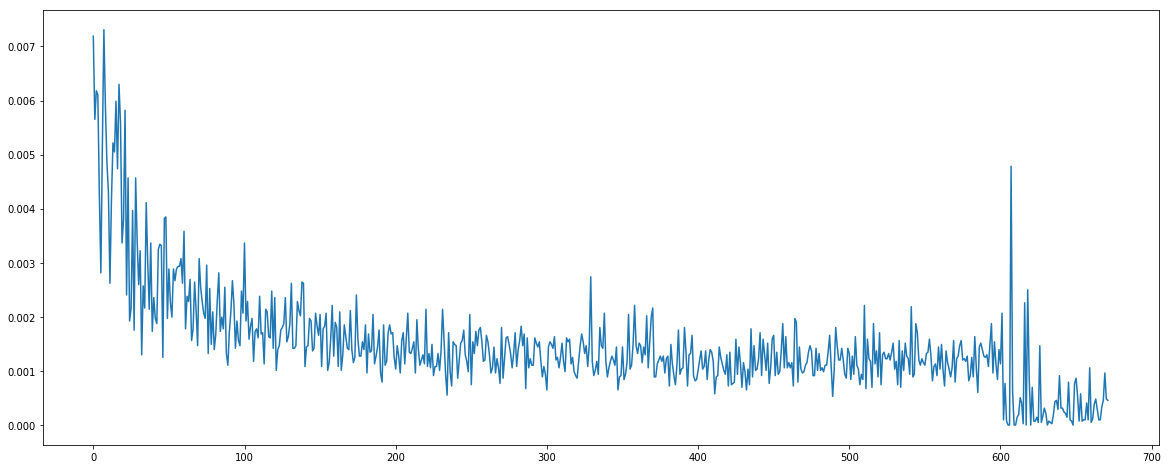

In [23]:
variableImportances.plot(figsize=(20,8))

In [30]:
namedVarImportances = pd.DataFrame({'feature_names': mergedXTrain.columns, 'importance':gbm.feature_importances_})
namedVarImportances[600:]

,feature_names,importance
600,ID,0.001130
601,drugCount,0.002068
602,ingredientCount,0.000096
603,timeCount,0.000770
604,quantitiesCount,0.000072
605,questionMarkCount,0.000000
606,sentenceCount,0.000000
607,wordCount,0.004785
608,combienCount,0.000625
609,pourquoiCount,0.000000


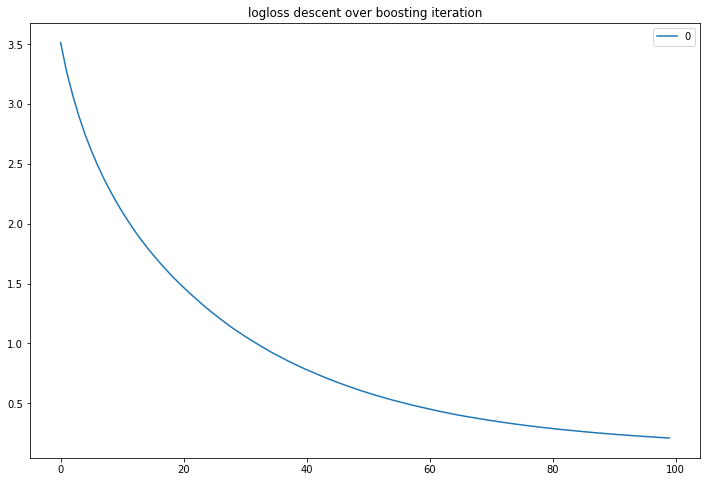

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(gbm.evals_result_.get('validation_0').get('mlogloss')).plot(figsize=(12,8), title='logloss descent over boosting iteration')

In [15]:
YPredicted = gbm.predict(mergedXTest)
YTrue = YTest.intention

d:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.72      0.37      0.49        35
          1       0.00      0.00      0.00         4
          2       1.00      0.20      0.33         5
          3       0.00      0.00      0.00         1
          4       1.00      0.73      0.84        11
          5       0.50      0.17      0.25        18
          6       1.00      0.50      0.67         4
          7       0.00      0.00      0.00         1
          8       0.81      0.52      0.63        25
          9       0.25      0.14      0.18         7
         10       0.75      0.50      0.60        12
         11       0.60      0.33      0.43        27
         12       0.33      0.50      0.40         6
         13       0.50      0.50      0.50        12
         14       0.48      0.52      0.50        42
         15       0.57      1.00      0.73         4
         16       0.00      0.00      0.00         3
         17       0.00      0.00      0.00   

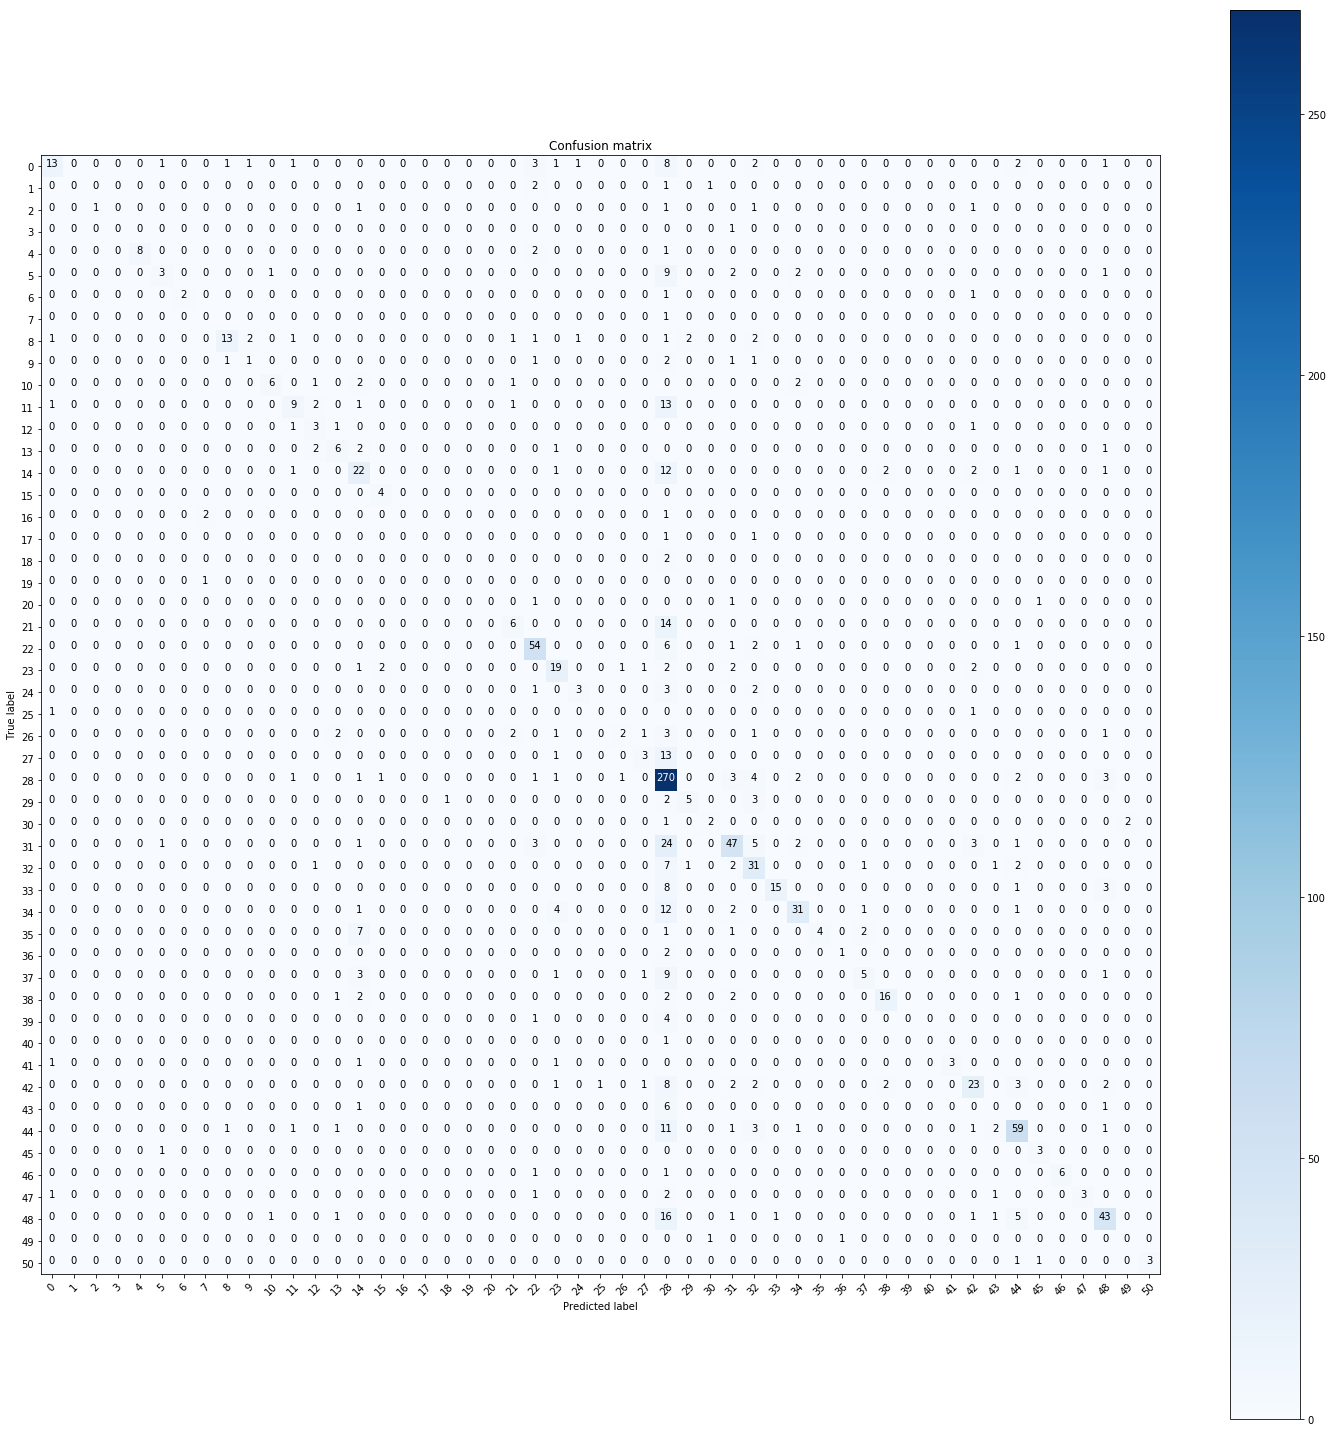

In [16]:

import sys
sys.path.append('..')
from utils import vizu

import sklearn
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(YTrue, YPredicted)

print(sklearn.metrics.classification_report(YTrue, YPredicted))

plt.figure(figsize=(20,20))

vizu.plot_confusion_matrix(cnf_matrix, normalize=False, classes = np.unique(YTrain['intention']))

plt.show()


In [17]:
macroF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='macro')
microF1Score = sklearn.metrics.f1_score(YTrue, YPredicted, average='micro')
print ("micro F1 score = {:1.4f} ; macro F1 score = {:1.4f}".format(microF1Score, macroF1Score))

micro F1 score = 0.6207 ; macro F1 score = 0.4083


d:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
